In [1]:
## custom
import lovasz_losses as L

## third party
from PIL import Image
from natsort import natsorted

## sys
import random
import time
from glob import glob

## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
# import umap.plot
# from umap import UMAP

## vis
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

/tmp/ipykernel_42474/589577732.py:37: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


## Utils

In [2]:
def colorScale2cmap(domain, range1):
    domain = np.array(domain)
    domain = (domain-domain.min())/(domain.max()-domain.min())
    range1 = np.array(range1)/255.0
    red = [r[0] for r in range1]
    green = [r[1] for r in range1]
    blue = [r[2] for r in range1]
    red = tuple((d,r,r) for d,r in zip(domain, red))
    green = tuple((d,r,r) for d,r in zip(domain, green))
    blue = tuple((d,r,r) for d,r in zip(domain, blue))
    return LinearSegmentedColormap('asdasdas', {'red':red, 'green': green, 'blue':blue})
    

#https://discuss.pytorch.org/t/efficient-distance-matrix-computation/9065/3
def pairwise_distances(x, y=None, w=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is None:
        y = x
        y_t = y.t()
        y_norm = x_norm
    else:
        y_t = y.t()
        y_norm = (y**2).sum(1).view(1, -1)
        
    if w is not None:
        x = x * w    
        y = y * w    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 0.0, np.inf)

x = torch.ones([5,2])
y = torch.zeros([3,2])
pairwise_distances(x,y)

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])

In [3]:
def file2graph(fn='./facebook/0.edges'):
    with open(fn) as f:
        lines = [l.split()[:2] for l in f.readlines()]
        edges = [tuple(int(i) for i in l) for l in lines]
        nodes = set(sum(edges, ())) ## SLOW?
#         edges += [(-1, n) for n in nodes]
#         nodes.update({-1})
    G = nx.Graph()
    G.add_nodes_from(list(nodes))
    G.add_edges_from(edges)
    return G


def dict2tensor(d, fill=None):
    n = len(d.keys())
    k2i = {k:i for i,k in enumerate(sorted(d.keys()))}
    res = torch.zeros(len(d.keys()), len(d.keys()), device=device)
    for src_node, dst_nodes in d.items():
        for dst_node, distance in dst_nodes.items():
            if fill is not None:
                res[k2i[src_node],k2i[dst_node]] = fill
            else:
                res[k2i[src_node],k2i[dst_node]] = distance
    return res, k2i


def draw_graph_3d(ax, x, G, grad=None, alpha=0.1):
    ax.scatter(x[:,0], x[:,1], x[:,2])
    # ax.view_init(elev=20.0, azim=0)
    edgeLines = [(x[k2i[e0]][:3], x[k2i[e1]][:3]) for e0,e1 in G.edges]
    lc = Line3DCollection(edgeLines, linewidths=1, alpha=alpha)
    ax.add_collection(lc)
    if grad is not None:
        ax.quiver(x[:,0], x[:,1], x[:,2], 
                 -grad[:,0], -grad[:,1], -grad[:,2], length=4, colors='C1')
    return ax

def plot(X, G, lossHistory, lrHistory, i, totalTime, show=False, save=True, grad=False):
    x = X.detach().cpu().numpy()
    
    if grad:
        grad = X.grad.data.cpu().numpy()
    else:
        grad = None
        
    fig = plt.figure(figsize=[12,5])
    if show:
        display.clear_output(wait=True)

    ## graph
    if x.shape[1] == 2:
        plt.subplot(121)
        nx.draw_networkx(G, 
                         pos={k: x[k2i[k],:2] for k in G.nodes}, 
                         node_size=30,
                         font_color='none')
        if grad is not None:
            plt.quiver(x[:,0], x[:,1], 
                       -grad[:,0], -grad[:,1], 
                       units='inches', label=f'neg grad (max={np.linalg.norm(grad, axis=1).max():.2e})')
            plt.legend()
        plt.axis('equal')
        
    else:
        ax = fig.add_subplot(1,2,1, projection='3d')
        ax = draw_graph_3d(ax, x, G, grad, alpha=0.01)
    plt.title(f'epoch: {i}, time: {int(totalTime)}s'.format(i))

    ## loss
    plt.subplot(122)
    plt.plot(lossHistory)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    ## Lr
#     plt.subplot(224)
#     plt.plot(lrHistory)
#     plt.xlabel('Epoch')
#     plt.ylabel('LR')

    if save:
        plt.savefig(f'fig/epoch{i}.png')
    
    if show:
        plt.show()
    else:
        plt.close()



colors = [
    [44,52,179],
    [0,0,0],
    [174,33,57],
]

## Optimization Procedures

In [4]:
## model criterion

def getSamples(G, n, includeNeighbors=True):
    seedNodes = random.sample(G.nodes, n)
    samples = set(seedNodes)
    if includeNeighbors:
        for i in seedNodes:
            neighbors = set(G.neighbors(i))
            samples.update(neighbors)
    samples = list(samples)
    return samples


def edge_uniformity(X, G, samples=None):
    edgeLengths = torch.stack([
        (X[k2i[e0]]-X[k2i[e1]]).norm() 
        for e0,e1 in G.edges 
        if (k2i[e0] in samples and k2i[e1] in samples)
    ])
    average = edgeLengths.mean()
    eu = ((edgeLengths-average)**2).mean() / average
    return eu


def stress(X, D, W, samples=None):
    X = X[samples,:]
    D = D[samples, :][:, samples]
    W = W[samples, :][:, samples]
    pdist_sqaured = pairwise_distances(X,X)
    diff = pdist_sqaured-D
    wbound = (1/4 * diff.abs().min()).item()
#     print(W.max(), wbound)
    W.clamp_(0, wbound)
    return (W*(diff)**2).mean()


def stress_update_ij(X, D, W, i, j, base_lr=1):
    with torch.no_grad():
        diff = X[i] - X[j]
        norm = diff.norm()
        r = (norm-D[i,j]) / 2 / (norm+0.001) * diff
        final_lr = min(0.99, base_lr * W[i,j])
        grad_xi = r
        grad_xj = -r
        X[i].data -= final_lr * grad_xi
        X[j].data -= final_lr * grad_xj


## generate a graph

In [8]:
%%time

print('generating graph...')
# G = nx.path_graph(10)
G = nx.cycle_graph(10000)
# G = nx.balanced_tree(2,7)
# G = nx.connected_watts_strogatz_graph(10,5,0.5)
# G = file2graph('./facebook/0.edges')
# G = file2graph('./facebook/107.edges')
# G = file2graph('./facebook/414.edges')
print(len(G.nodes), 'nodes')

print('calculating all pairs shortest path...')
D, k2i = dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
W = 1/(D+1)**2

Adj,_ = dict2tensor(dict(G.adjacency()), fill=1)
print('\n\n')

neighborSizes = Adj.sum(dim=1).int()
nodeCount = Adj.shape[0]
eye = torch.eye(Adj.shape[0], device=device)
truth = Adj + eye


generating graph...
10000 nodes
calculating all pairs shortest path...



CPU times: user 19min 55s, sys: 5.83 s, total: 20min
Wall time: 19min 46s


## Optimize via Stochastic Gradient Descent (SGD)

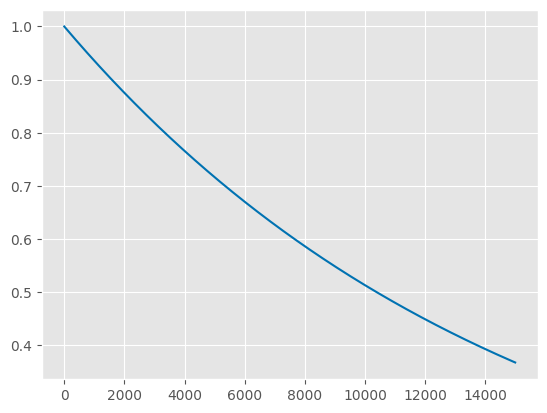

In [9]:
# delete old
!rm -r fig
!mkdir fig

X = torch.rand(len(G.nodes), 2, device=device)
X.requires_grad_(True)

lr = 1
optimizer = optim.SGD([X], lr=lr)
scheduler = None

##functions
lossHistory = []

niter = 15000
totalTime = 0

def getLR(i):
    base_lr = 1
    return np.exp(-i/niter) * base_lr
lrs = [getLR(i) for i in range(niter)]
plt.plot(lrs)

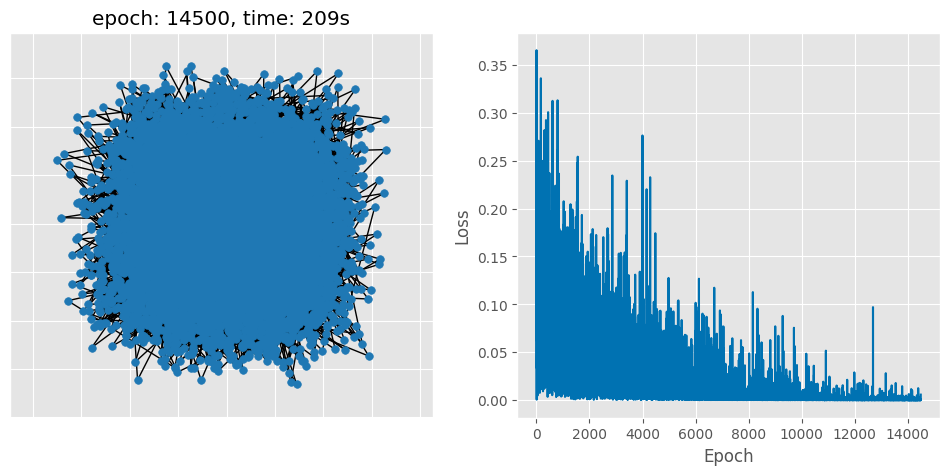

In [10]:
iterBar = tqdm(range(niter))
for i in iterBar:
    
    t0 = time.time()
    if X.grad is not None:
        X.grad.data.fill_(0)
        
    samples = getSamples(G, 5, includeNeighbors=False)
    for si, src in enumerate(samples):
        for dst in samples[si+1:]:
            stress_update_ij(X, D, W, src, dst, getLR(i))
            
    samples = getSamples(G, 3)
    eu = edge_uniformity(X, G, samples)
    loss = eu
    loss.backward()
    optimizer.step()
    
    if scheduler is not None:
        scheduler.step()
    dt = time.time() - t0
    totalTime += dt
    
    ##debug info
    lossHistory.append(loss.item())
    ##vis
    if i%500==0:
        iterBar.set_postfix({
            'loss': loss.item(),
            'eu': f'{eu.item():.2e}',
#             'st': f'{st.item():.2e}',
        })
        plot(X, G, lossHistory, [], i, totalTime, show=True, save=True, grad=False)
    

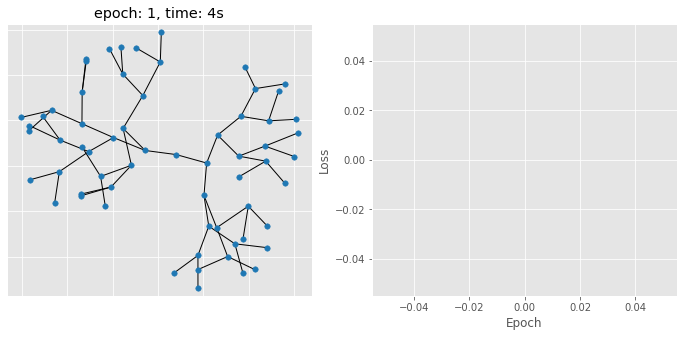

In [232]:
plot(X, G, [], [], i, totalTime, show=True, save=True, grad=False)

## animation

In [494]:
# Create a gif from images in fig/

frames = []
imgs = natsorted(glob('fig/*.png'))

for img in imgs:
    new_frame = Image.open(img)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)